In [3]:
import pandas as pd
import numpy as np
from pymoo.indicators.hv import Hypervolume
from ax.service.ax_client import AxClient
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib

# Get the raw data

In [4]:
# Load the data from the Excel and CSV files

design_file_path = "DOE.xlsx"
size_file_path = "Size_result.csv"
conc_file_path = "Solubility_result.xlsx"

In [5]:
# Read the data from the files

doe = pd.read_excel(design_file_path)
size = pd.read_csv(size_file_path, encoding='ISO-8859-1')
conc = pd.read_excel(conc_file_path, sheet_name='sample')
calibration = pd.read_excel(conc_file_path, sheet_name='standard')

In [6]:
# Extract the relevant columns from the dataframes
size_pdi = size[['Item','Diameter (nm)', 'PD Index']]

In [7]:
# Extract the relevant columns from the calibration dataframe

def map_item_to_formulation(item):
    letter = item[0]
    number = int(item[1])
    
    letter_base = {
        'A': 0, 'B': 1, 'C': 2, 'D': 3,
        'E': 4, 'F': 5, 'G': 6, 'H': 7
    }
    
    if letter not in letter_base:
        return "Unknown"

    base = letter_base[letter]
    
    if 1 <= number <= 3:
        formulation_group = base
        formulation_number = number
    elif 4 <= number <= 6:
        formulation_group = base + 8
        formulation_number = number - 3
    elif 7 <= number <= 9:
        formulation_group = base + 16
        formulation_number = number - 6
    else:
        return "Unknown"

    return formulation_group, formulation_number


In [8]:
# Apply the mapping function to the 'Item' column

size_pdi[['Formulation', 'n']] = pd.DataFrame(size_pdi['Item'].apply(map_item_to_formulation).tolist(),index=size_pdi.index)

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_40863/2692015105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_pdi[['Formulation', 'n']] = pd.DataFrame(size_pdi['Item'].apply(map_item_to_formulation).tolist(),index=size_pdi.index)
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_40863/2692015105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_pdi[['Formulation', 'n']] = pd.DataFrame(size_pdi['Item'].apply(map_item_to_formulation).tolist(),index=size_pdi.index)


In [9]:
# Sort the DataFrame by 'Formulation' and 'n'

size_pdi = size_pdi.sort_values(by=['Formulation', 'n'])
size_pdi = size_pdi.reset_index(drop=True)
size_pdi

,Item,Diameter (nm),PD Index,Formulation,n
0,A1,29.836711,0.209146,0,1
1,A2,29.919789,0.195315,0,2
2,A3,30.901737,0.200902,0,3
3,B1,28.061385,0.137706,1,1
4,B2,28.595727,0.133869,1,2
5,B3,29.175415,0.188559,1,3
6,C1,27.039628,0.169080,2,1
7,C2,28.173991,0.187271,2,2
8,C3,27.830393,0.190339,2,3
9,D1,57.069129,0.325728,3,1


In [10]:
# Calculate the calibration curve

y = calibration['AUC'].values.reshape(-1, 1)  
X = calibration['Sample'].values.reshape(-1, 1)  
model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R2: {r2}")


Slope: [17.94978748]
Intercept: [14.98367248]
R2: 0.9999809421037803


In [11]:
# Calculate the concentration based on the calibration curve

dilution = 10

conc['Concentration (µg/mL)'] = (conc['AUC'] - intercept) / slope * dilution
conc.head()


,Item,AUC,Volume,Concentration (µg/mL)
0,0.0,181.182,2.7,92.590694
1,NaN,199.128,2.7,102.588584
2,NaN,251.346,2.7,131.679736
3,1.0,2009.004,2.7,1110.887986
4,NaN,1995.699,2.7,1103.475642


In [12]:
# Add in concentration data

size_pdi['Concentration (µg/mL)'] = conc['Concentration (µg/mL)']
raw_data = size_pdi.copy()
raw_data.head()

,Item,Diameter (nm),PD Index,Formulation,n,Concentration (µg/mL)
0,A1,29.836711,0.209146,0,1,92.590694
1,A2,29.919789,0.195315,0,2,102.588584
2,A3,30.901737,0.200902,0,3,131.679736
3,B1,28.061385,0.137706,1,1,1110.887986
4,B2,28.595727,0.133869,1,2,1103.475642


In [13]:
# Calculate the mean and standard deviation for each formulation

def summarize(df, column):

    mean_list = []
    std_list = []

    for _, data in df.groupby('Formulation'):

        mean = data[column].mean()
        std = data[column].std()

        mean_list.append(mean)
        std_list.append(std)

    summary = pd.DataFrame()
    summary['Formulation'] = df['Formulation'].unique()
    summary[column] = mean_list
    summary[column + '_std'] = std_list

    return summary

In [14]:
# Summarize the data

summary_size = summarize(raw_data, 'Diameter (nm)')
summary_pdi = summarize(raw_data, 'PD Index')
summary_conc = summarize(raw_data, 'Concentration (µg/mL)')

In [15]:
# Merge the summaries back into the original DataFrame

doe['Size (nm)'] = summary_size['Diameter (nm)']
doe['Size (nm)_std'] = summary_size['Diameter (nm)_std']
doe['PDI'] = summary_pdi['PD Index']
doe['PDI_std'] = summary_pdi['PD Index_std']
doe['Concentration (µg/mL)'] = summary_conc['Concentration (µg/mL)']
doe['Concentration (µg/mL)_std'] = summary_conc['Concentration (µg/mL)_std']

doe['Solubilization'] = doe['Concentration (µg/mL)']/(doe['Drug']/100 * 6000/2.7)*100
doe['Solubilization_std'] = doe['Concentration (µg/mL)_std']/(doe['Drug']/100 * 6000/2.7)*100

doe['Formulation Index'] = summary_conc['Formulation']

stable_formulations = {12, 13, 16, 18, 19}


doe['Stability'] = doe['Formulation Index'].apply(lambda x: 1 if x in stable_formulations else 0)

# Build a dictionary mapping each stable formulation index to its values: index -> (conc, conc_std, size, size_std, pdi, pdi_std)
stable_info = {
    12: (367.9247316, 10.23567711, 118.7456524, 4.554845623, 0.154497896, 0.006164143),
    13: (939.7022223, 18.97338521, 114.8417277, 2.325583815, 0.197397247, 0.035893784),
    16: (306.3447006, 7.227094123, 130.8124935, 2.596827926, 0.167087338, 0.007799504),
    18: (400.5129212, 3.471378275, 161.1962836, 2.356494172, 0.115346618, 0.010219937),
    19: (175.4277098, 8.257180838, 151.9126165, 6.344866057, 0.139975486, 0.0396645),
}

# Define helper to extract each value
def get_stable_value(x, i):
    return stable_info.get(x, (None,) * 6)[i]

# Apply logic to populate new columns
doe['Stable_Concentration (µg/mL)'] = doe['Formulation Index'].apply(lambda x: get_stable_value(x, 0))
doe['Stable_Concentration (µg/mL)_std'] = doe['Formulation Index'].apply(lambda x: get_stable_value(x, 1))
doe['Stable_Size (nm)'] = doe['Formulation Index'].apply(lambda x: get_stable_value(x, 2))
doe['Stable_Size (nm)_std'] = doe['Formulation Index'].apply(lambda x: get_stable_value(x, 3))
doe['Stable_PDI'] = doe['Formulation Index'].apply(lambda x: get_stable_value(x, 4))
doe['Stable_PDI_std'] = doe['Formulation Index'].apply(lambda x: get_stable_value(x, 5))

doe['Formulation Index'] = summary_conc['Formulation'] + 1
doe

,Unnamed: 0,LL2,LL3,P3,S2,Drug,Size (nm),Size (nm)_std,PDI,PDI_std,...,Solubilization,Solubilization_std,Formulation Index,Stability,Stable_Concentration (µg/mL),Stable_Concentration (µg/mL)_std,Stable_Size (nm),Stable_Size (nm)_std,Stable_PDI,Stable_PDI_std
0,0,0,0,30,0.25,70,30.219412,0.592369,0.201788,0.006958,...,7.004122,1.305440,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,40,0.50,60,28.610842,0.557169,0.153378,0.030528,...,84.625751,2.762981,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,50,0.75,50,27.681337,0.581686,0.182230,0.011491,...,85.755856,0.461943,3,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,10,30,0.50,60,55.350870,2.067760,0.316728,0.007817,...,85.297653,1.526938,4,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,10,40,0.75,50,45.915981,1.653551,0.388698,0.018326,...,89.099149,1.338610,5,0,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0,20,30,0.75,50,90.237636,2.725772,0.253659,0.015117,...,87.075972,0.796961,6,0,NaN,NaN,NaN,NaN,NaN,NaN
6,6,0,20,50,0.25,30,79.304611,1.195653,0.176168,0.017583,...,82.191725,1.748945,7,0,NaN,NaN,NaN,NaN,NaN,NaN
7,7,10,0,30,0.50,60,64.224255,2.075304,0.343410,0.017720,...,86.596833,0.392243,8,0,NaN,NaN,NaN,NaN,NaN,NaN
8,8,10,0,40,0.75,50,60.418362,5.489192,0.419868,0.124659,...,91.276824,1.120923,9,0,NaN,NaN,NaN,NaN,NaN,NaN
9,9,10,10,30,0.75,50,102.121064,1.937296,0.216838,0.018321,...,91.726144,2.216333,10,0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Create a new DataFrame with the relevant columns for stability analysis

stability = doe[['Formulation Index', 'Stability', 'Size (nm)', 'Size (nm)_std', 'Stable_Size (nm)', 'Stable_Size (nm)_std', 'PDI', 'PDI_std', 'Stable_PDI', 'Stable_PDI_std', 'Concentration (µg/mL)', 'Concentration (µg/mL)_std', 'Stable_Concentration (µg/mL)', 'Stable_Concentration (µg/mL)_std',  ]]
stability = stability[stability['Stability'] == 1]
stability


,Formulation Index,Stability,Size (nm),Size (nm)_std,Stable_Size (nm),Stable_Size (nm)_std,PDI,PDI_std,Stable_PDI,Stable_PDI_std,Concentration (µg/mL),Concentration (µg/mL)_std,Stable_Concentration (µg/mL),Stable_Concentration (µg/mL)_std
12,13,1,114.814519,5.052665,118.745652,4.554846,0.153797,0.037656,0.154498,0.006164,394.886195,6.134719,367.924732,10.235677
13,14,1,96.688149,12.007675,114.841728,2.325584,0.176077,0.011414,0.197397,0.035894,978.751417,10.620461,939.702222,18.973385
16,17,1,132.226950,4.903461,130.812493,2.596828,0.126758,0.012056,0.167087,0.007800,394.700677,5.568257,306.344701,7.227094
18,19,1,159.167236,3.306652,161.196284,2.356494,0.134399,0.014821,0.115347,0.010220,401.501686,6.321418,400.512921,3.471378
19,20,1,147.958419,3.183644,151.912617,6.344866,0.150439,0.033800,0.139975,0.039664,186.659403,2.255403,175.427710,8.257181


In [17]:
# Plot the stability analysis

def plot_stability_comparisons(df, properties, std_suffix='_std'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)
    subplot_labels = ['a)', 'b)', 'c)']

    for i, prop in enumerate(properties):
        ax = axes[i]
        labels = df['Formulation Index'].astype(str)
        
        before = df[prop]
        before_std = df[prop + std_suffix]
        

        after = df['Stable_' + prop]
        after_std = df['Stable_' + prop + std_suffix]
        
        x_labels = df['Formulation Index'].astype(str)
        x = np.arange(len(x_labels))



        width = 0.35
        
        ax.bar(x - width/2, before, width, yerr=before_std, label='Before stability study', capsize=5)
        ax.bar(x + width/2, after, width, yerr=after_std, label='After stability study', capsize=5)

        ax.set_title(f"{subplot_labels[i]}", loc='left', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0)
        ax.set_xlabel('Formulation Index')

        ax.set_ylabel(prop)
#        ax.grid(True, linestyle='--', alpha=0.5)
        if i == 0:
            ax.legend()

    plt.tight_layout()

    plt.savefig("Stability.png", dpi=600, transparent=True)
    
    plt.show()


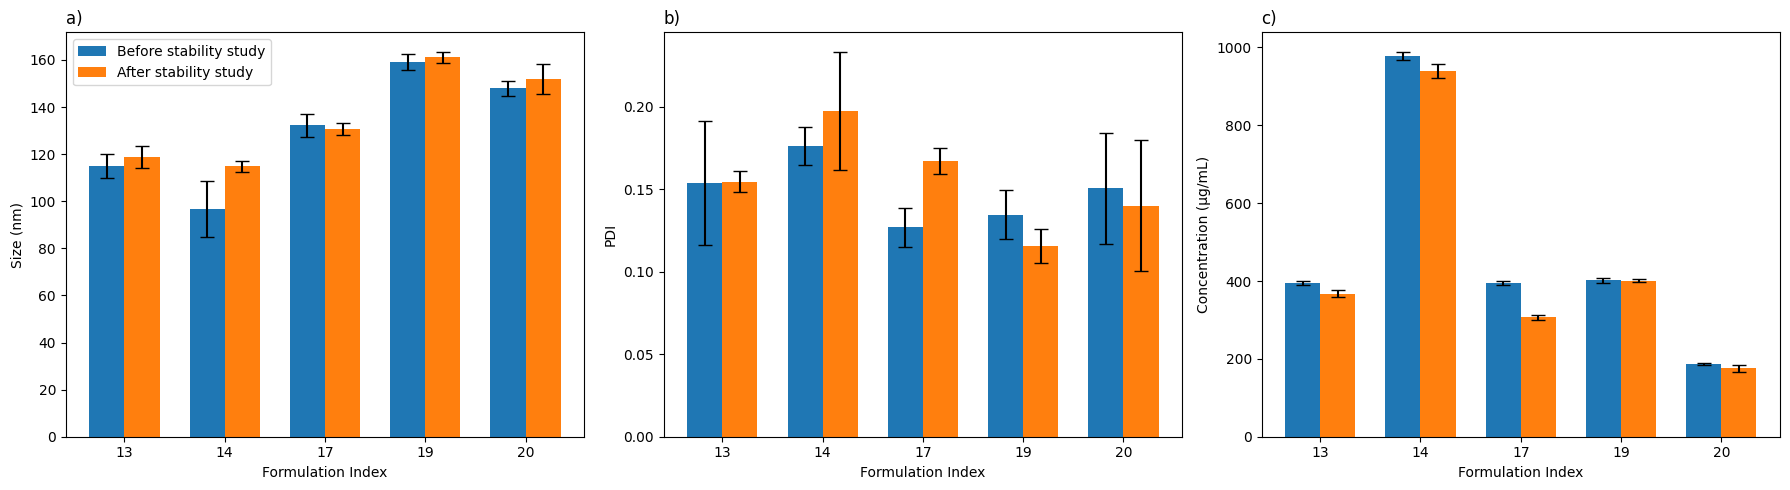

In [18]:
# Plot the stability analysis


properties = [
    'Size (nm)',
    'PDI',
    'Concentration (µg/mL)'
]

plot_stability_comparisons(stability, properties)


In [19]:
# Data normalization

doe_norm = doe.copy()
doe_norm['Size (nm)'] = doe['Size (nm)']/1000
doe_norm['Size (nm)_std'] = doe['Size (nm)_std']/1000
doe_norm['Concentration (µg/mL)'] = doe['Concentration (µg/mL)']/(6000/2.7)
doe_norm['Concentration (µg/mL)_std'] = doe['Concentration (µg/mL)_std']/(6000/2.7)
doe_norm['Solubilization'] = doe['Solubilization']/100
doe_norm

,Unnamed: 0,LL2,LL3,P3,S2,Drug,Size (nm),Size (nm)_std,PDI,PDI_std,...,Solubilization,Solubilization_std,Formulation Index,Stability,Stable_Concentration (µg/mL),Stable_Concentration (µg/mL)_std,Stable_Size (nm),Stable_Size (nm)_std,Stable_PDI,Stable_PDI_std
0,0,0,0,30,0.25,70,0.030219,0.000592,0.201788,0.006958,...,0.070041,1.305440,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,40,0.50,60,0.028611,0.000557,0.153378,0.030528,...,0.846258,2.762981,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,50,0.75,50,0.027681,0.000582,0.182230,0.011491,...,0.857559,0.461943,3,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,10,30,0.50,60,0.055351,0.002068,0.316728,0.007817,...,0.852977,1.526938,4,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,10,40,0.75,50,0.045916,0.001654,0.388698,0.018326,...,0.890991,1.338610,5,0,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0,20,30,0.75,50,0.090238,0.002726,0.253659,0.015117,...,0.870760,0.796961,6,0,NaN,NaN,NaN,NaN,NaN,NaN
6,6,0,20,50,0.25,30,0.079305,0.001196,0.176168,0.017583,...,0.821917,1.748945,7,0,NaN,NaN,NaN,NaN,NaN,NaN
7,7,10,0,30,0.50,60,0.064224,0.002075,0.343410,0.017720,...,0.865968,0.392243,8,0,NaN,NaN,NaN,NaN,NaN,NaN
8,8,10,0,40,0.75,50,0.060418,0.005489,0.419868,0.124659,...,0.912768,1.120923,9,0,NaN,NaN,NaN,NaN,NaN,NaN
9,9,10,10,30,0.75,50,0.102121,0.001937,0.216838,0.018321,...,0.917261,2.216333,10,0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# hypervolume/pareto front calculation

def hv(df_norm):
    
    data = df_norm.copy()
    data['Concentration (µg/mL)_min'] = -data['Concentration (µg/mL)']
#    data['Solubilization_min'] = -data['Solubilization']
    data['Stability_min'] = -data['Stability']

    # Select relevant objectives for hypervolume calculation
    objectives = ['Size (nm)', 'PDI', 'Concentration (µg/mL)_min', 'Stability_min']

    # Define the reference point (worst case + 20%)
    reference_point = [1.2, 1.2, 0.2, 0.2]

    hv_values = []

    for trial in sorted(data['Formulation Index']):
        formulation = data[data['Formulation Index'] == trial][objectives].values
        hv = Hypervolume(ref_point=reference_point)
        hv_values.append(hv.do(formulation))
        hv_values.append(trial)
    
    # Perform non-dominated sorting to determine Pareto front
    nds = NonDominatedSorting()
    pareto_fronts = nds.do(data[objectives].values)
    
    # Create a list to indicate Pareto front membership (1 for Pareto front, 0 otherwise)
    pareto_flags = [1 if i in pareto_fronts[0] else 0 for i in range(len(data))]

    return hv_values[::2], pareto_flags

In [21]:
# hypervolume/pareto front calculation 

doe['Hypervolume'], doe['Pareto'] = hv(doe_norm)   


In [22]:
# Plot the distribution

def distribution(x, y , ax , ann):

    fontsize = 24

    unique_levels = sorted(doe[x].unique(), key=int)  # Sort as integers
    num_levels = len(unique_levels)

    colors = sns.color_palette("Blues", num_levels)  # Using Blues colormap for gradient effect
    color_map = {str(iteration): colors[i] for i, iteration in enumerate(unique_levels)}  # Ensure keys are strings

    sns.boxplot(
    x=doe[x], 
    y=doe[y], 
    palette=color_map,  # Apply the color mapping
    linewidth=0.5,  # Set border width
    boxprops={'edgecolor': 'black'},  # Set border color
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'},
    medianprops={'color': 'black'},
    showfliers=False,  # Hide outlier circles
    ax=ax  # Use the provided axis
    )


    # Add jittered scatter points with transparent fill and black edge
    for i, level in enumerate(unique_levels):
        subset = doe[doe[x] == level]
        x_jittered = np.random.normal(loc=i, scale=0.1, size=len(subset))  # Adding jitter
        ax.scatter(x_jittered, subset[y], color='none', edgecolors='black', alpha=0.5, zorder=3)  # Bring scatters to front

    # Adjust font sizes
    ax.set_xlabel(x, fontsize=fontsize )
    ax.set_ylabel(y, fontsize=fontsize )

    # Format y-axis ticks to show fewer decimals

    if y == 'Stability':
        ax.set_yticks([0, 1])  # Ensure only 0 and 1 as y-ticks

    if (y == 'PDI'):
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
        ax.set_yticklabels([f'{tick:.2f}' for tick in ax.get_yticks()], fontsize=fontsize)
    else:
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        ax.set_yticklabels([f'{tick:.0f}' for tick in ax.get_yticks()], fontsize=fontsize)
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


    ax.annotate(ann, xy=(0, 1.10), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)



/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_40863/293359335.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_40863/293359335.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}' for tick in ax.get_yticks()], fontsize=fontsize)
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_40863/293359335.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_40863/293359335.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecate

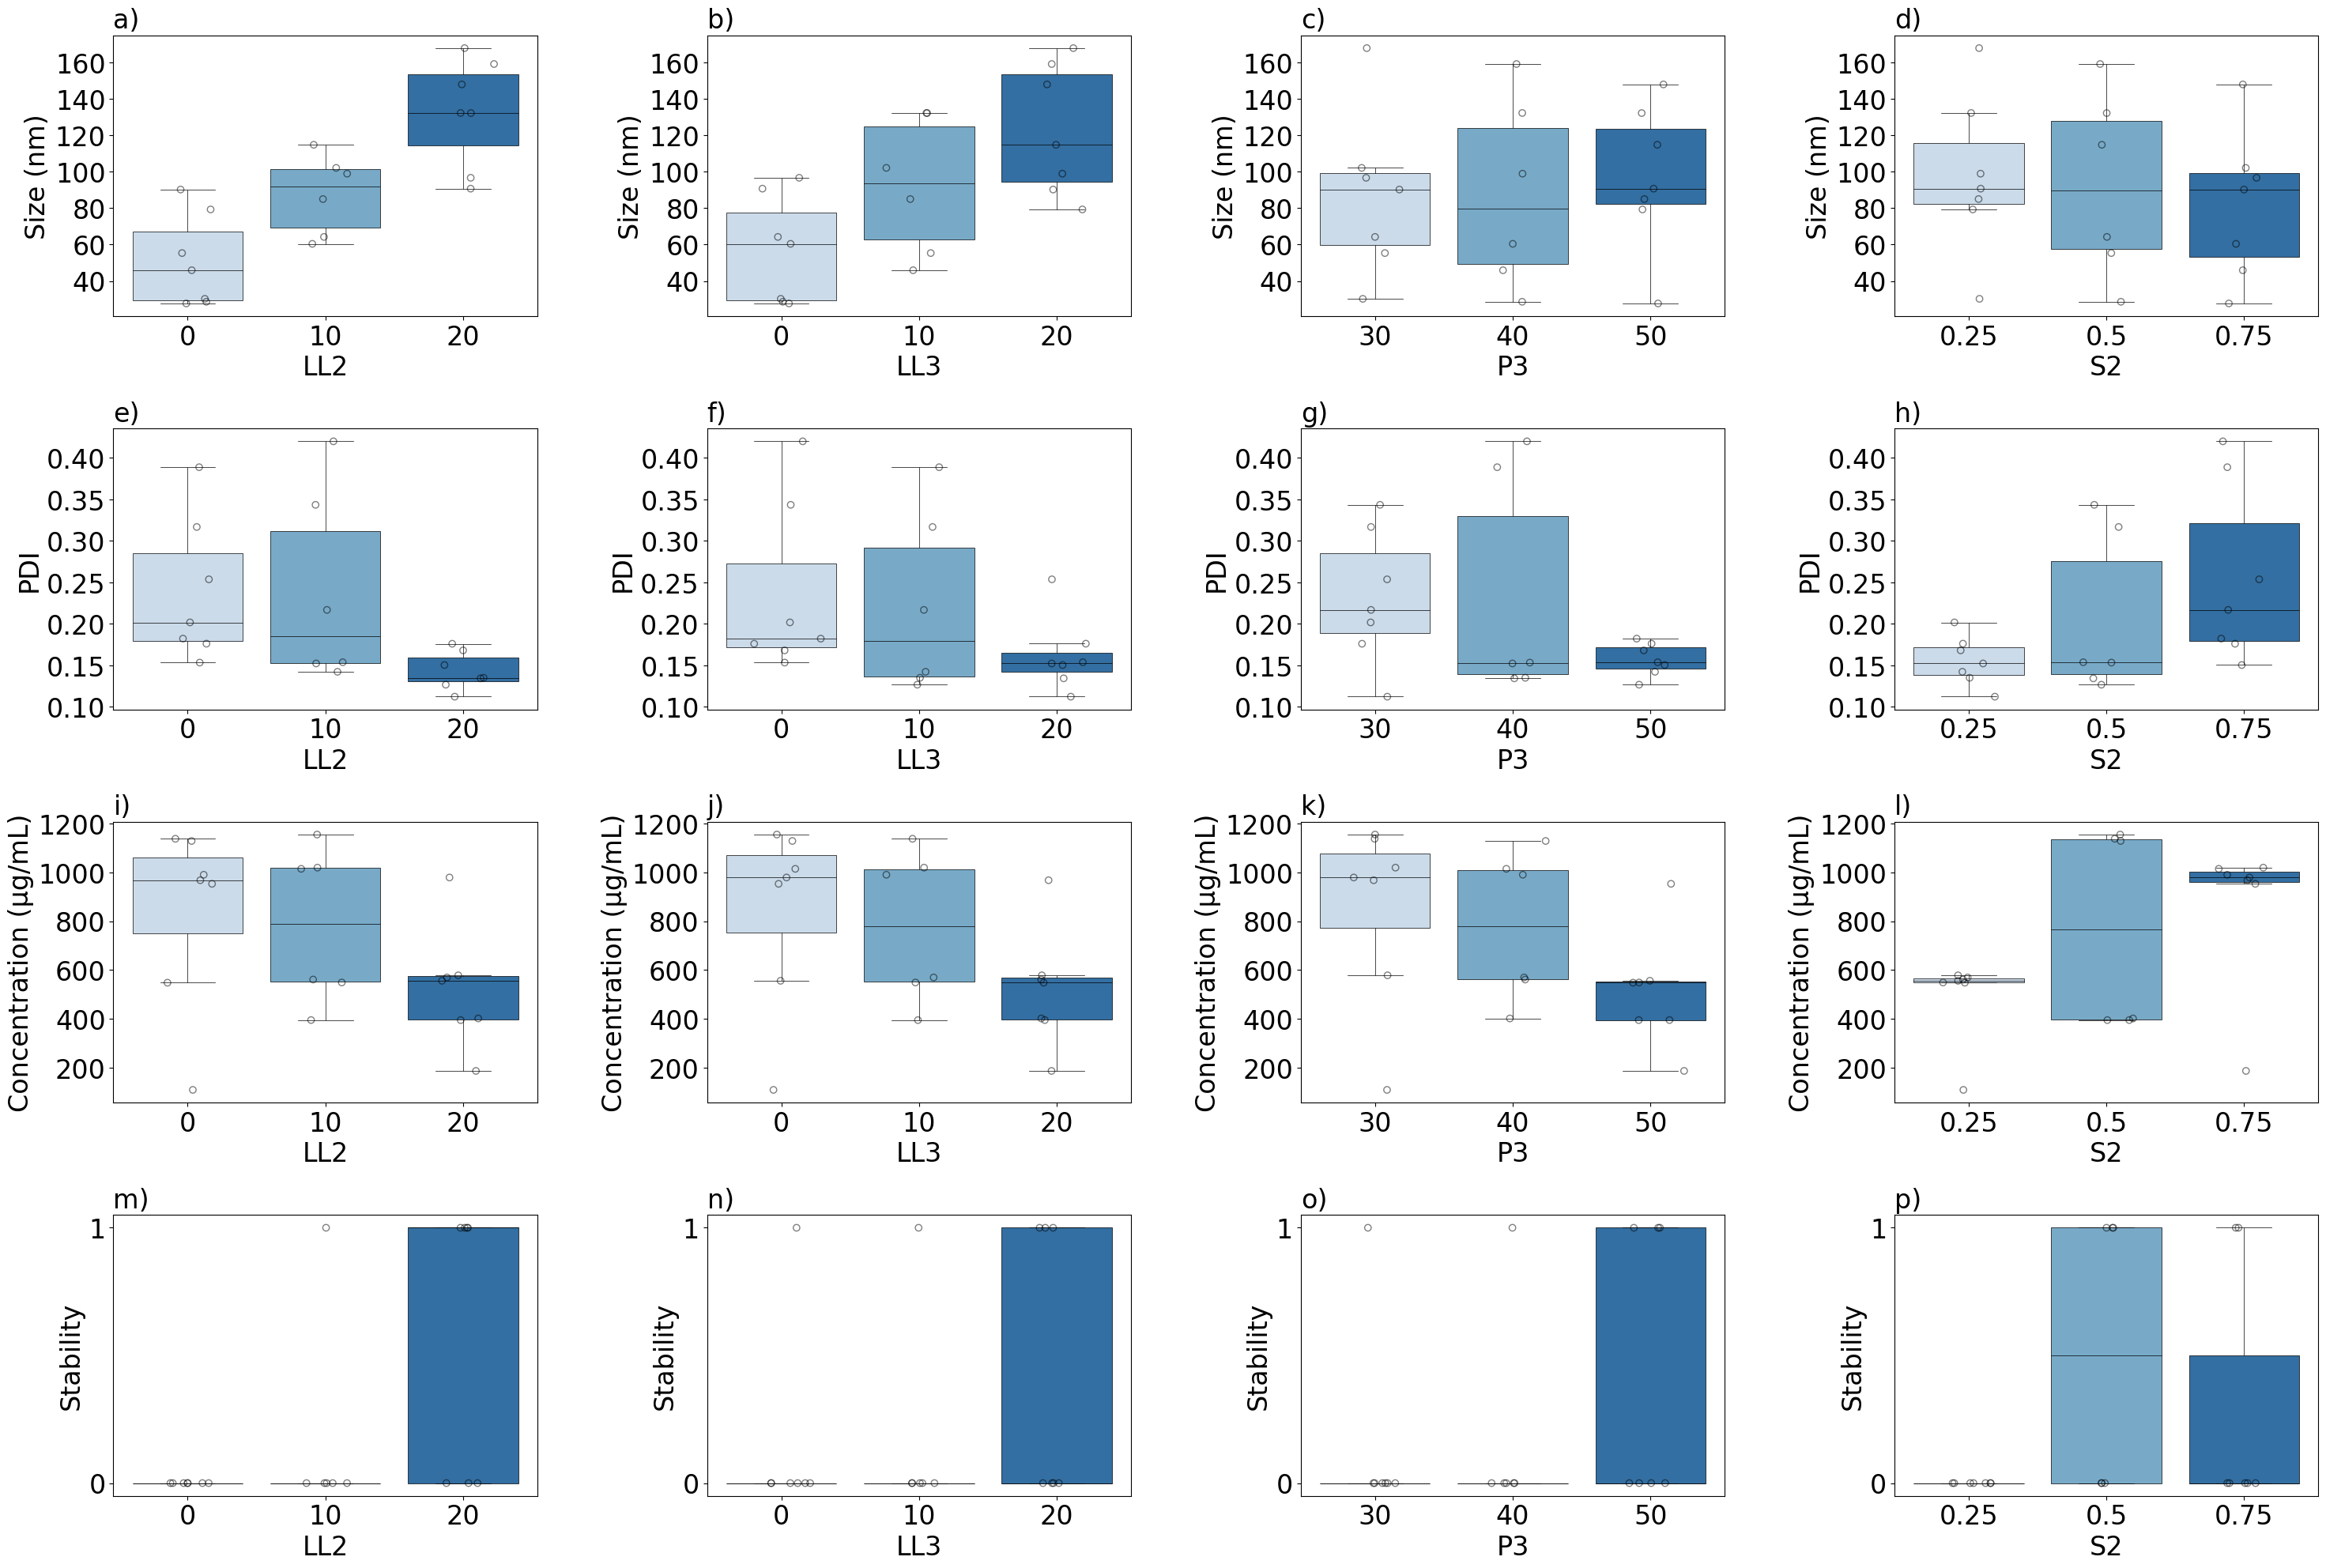

In [23]:
# Plot the distribution

fig = plt.figure(figsize=(36, 24))
grid = plt.GridSpec(4, 4, wspace=0.4, hspace=0.4)

x_list = [ 'LL2', 'LL3', 'P3', 'S2']
y_list = ['Size (nm)', 'PDI', 'Concentration (µg/mL)', 'Stability']

# Counter for annotation labels, starting with 'a'
letter_index = 97  # ASCII value for 'a'

for i, y in enumerate(y_list):
    for j, x in enumerate(x_list):
        ax = fig.add_subplot(grid[i, j])  # Corrected index for subplot
        ann_text = f"{chr(letter_index)})"  # Format as 'a)', 'b)', 'c)', etc.
        distribution(x, y, ax, ann_text)
        letter_index += 1  # Move to the next letter

fig.patch.set(facecolor='none')
fig.canvas.print_figure('Distribution.png', dpi=600)
plt.show()


In [24]:
# Save the data to an Excel file

columns_to_save = ['Formulation Index','Drug', 'LL2', 'LL3', 'P3', 'S2',  'Concentration (µg/mL)', 'Size (nm)', 'PDI', 'Stability', 'Pareto']


table = doe[columns_to_save].copy()


table['Concentration (µg/mL)'] = round(doe['Concentration (µg/mL)'],2).astype(str) + ' ± ' + round(doe['Concentration (µg/mL)_std'],2).astype(str)
table['Size (nm)'] = round(doe['Size (nm)'],2).astype(str) + ' ± ' + round(doe['Size (nm)_std'],2).astype(str)
table['PDI'] = round(doe['PDI'],2).astype(str) + ' ± ' + round(doe['PDI_std'],2).astype(str)
table["S2"] = table["S2"].apply(lambda x: f"{x:.2f}%")
table["Drug"] = table["Drug"].apply(lambda x: f"{x:.0f}%")
table["LL2"] = table["LL2"].apply(lambda x: f"{x:.0f}%")
table["LL3"] = table["LL3"].apply(lambda x: f"{x:.0f}%")
table["P3"] = table["P3"].apply(lambda x: f"{x:.0f}%")
table['Formulation Index'] = table.index + 1


table.to_excel('Table.xlsx', index=False)
table

,Formulation Index,Drug,LL2,LL3,P3,S2,Concentration (µg/mL),Size (nm),PDI,Stability,Pareto
0,1,70%,0%,0%,30%,0.25%,108.95 ± 20.31,30.22 ± 0.59,0.2 ± 0.01,0,0
1,2,60%,0%,0%,40%,0.50%,1128.34 ± 36.84,28.61 ± 0.56,0.15 ± 0.03,0,1
2,3,50%,0%,0%,50%,0.75%,952.84 ± 5.13,27.68 ± 0.58,0.18 ± 0.01,0,1
3,4,60%,0%,10%,30%,0.50%,1137.3 ± 20.36,55.35 ± 2.07,0.32 ± 0.01,0,1
4,5,50%,0%,10%,40%,0.75%,989.99 ± 14.87,45.92 ± 1.65,0.39 ± 0.02,0,0
5,6,50%,0%,20%,30%,0.75%,967.51 ± 8.86,90.24 ± 2.73,0.25 ± 0.02,0,0
6,7,30%,0%,20%,50%,0.25%,547.94 ± 11.66,79.3 ± 1.2,0.18 ± 0.02,0,0
7,8,60%,10%,0%,30%,0.50%,1154.62 ± 5.23,64.22 ± 2.08,0.34 ± 0.02,0,1
8,9,50%,10%,0%,40%,0.75%,1014.19 ± 12.45,60.42 ± 5.49,0.42 ± 0.12,0,0
9,10,50%,10%,10%,30%,0.75%,1019.18 ± 24.63,102.12 ± 1.94,0.22 ± 0.02,0,0


In [25]:
# Plot the contour plots


def contour(data, prop_1, prop_2, ax, ann, scheme='Blues'):
    fontsize = 16

    sns.kdeplot(
        data=data, x=prop_1, y=prop_2,
        levels=10,  
        thresh=0.1,  
        fill=True,  
        cmap=scheme,  
        alpha=0.75,  
        ax=ax,
        cut=2
    )

    # Overlay scatter plot with different markers for stability
    scatter = sns.scatterplot(
        data=data, x=prop_1, y=prop_2,
        hue='Pareto',
        style='Stability',  # Different marker for stable/unstable
        palette={0: 'blue', 1: 'red'},
        markers={0: 'o', 1: 'X'},  # Circle for unstable, X for stable
        edgecolor="white",
        alpha=0.7,
        s=60,
        ax=ax
    )

    # Show legend only for subplot (b)
    if ann == 'b)':
        from matplotlib.lines import Line2D
        
        legend_items = [
            
            Line2D([0], [0], marker='X', color='red', linestyle='', markersize=8, label='Pareto (Stable)') ,
            Line2D([0], [0], marker='o', color='red', linestyle='', markersize=8, label='Pareto (Unstable)'),
            Line2D([0], [0], marker='X', color='blue', linestyle='', markersize=8, label='Non-Pareto (Stable)') ,
            Line2D([0], [0], marker='o', color='blue', linestyle='', markersize=8, label='Non-Pareto (Unstable)') ,

        ]
        
        ax.legend(handles=legend_items, loc='upper center', bbox_to_anchor=(0.5, 1.20), 
                  ncol=4, frameon=False, fontsize=fontsize, markerscale=1.)
    else:
        scatter.legend_.remove()
    
    # Improve axis labels


    def direction(prop):
        if prop == 'Size (nm)' or prop == 'PDI':
            return ' (To minimize)'
        elif prop == 'Concentration (µg/mL)':
            return ' (To maximize)'


    plt.xlabel(prop_1 + direction(prop_1), fontsize=fontsize)
    plt.ylabel(prop_2 + direction(prop_2), fontsize=fontsize)

    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)

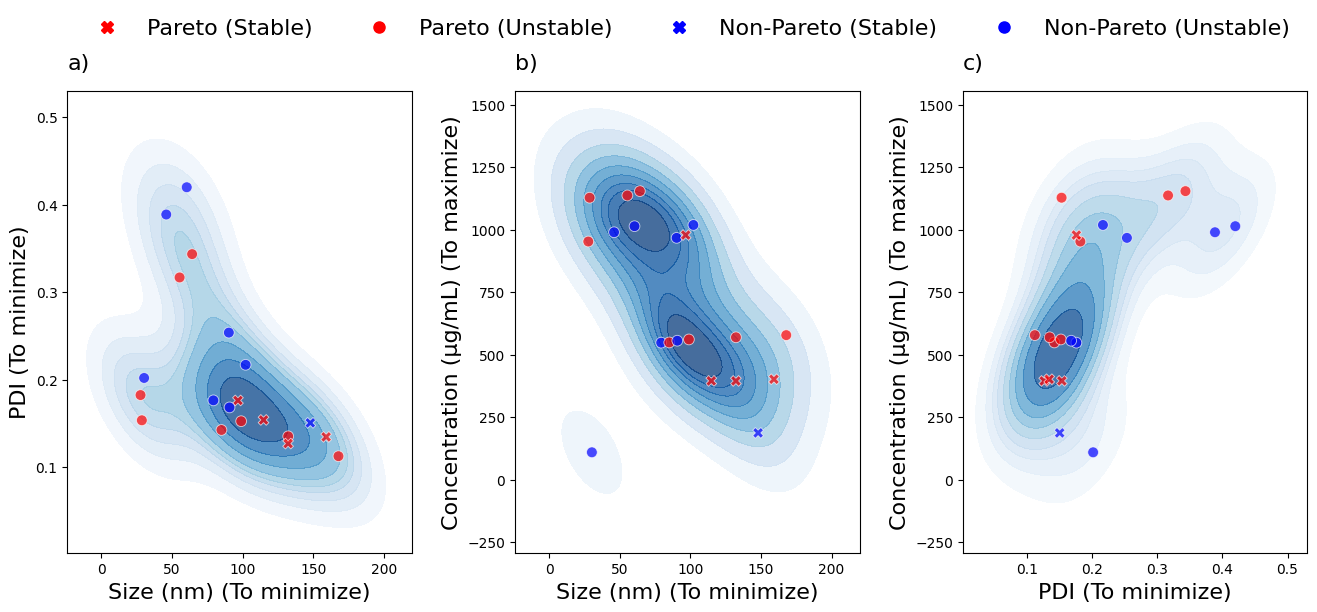

In [26]:
# Plot the contour plots

fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(1, 3, wspace=0.3, hspace=0.2)

ax1 = fig.add_subplot(grid[0, 0])
contour(doe, 'Size (nm)', 'PDI', ax1, 'a)')

ax2 = fig.add_subplot(grid[0, 1])
contour(doe, 'Size (nm)', 'Concentration (µg/mL)', ax2, 'b)')

ax3 = fig.add_subplot(grid[0, 2])
contour(doe, 'PDI', 'Concentration (µg/mL)', ax3, 'c)')


fig.patch.set(facecolor='none')
fig.canvas.print_figure('Contour.png', dpi=600)
plt.show()
